In [1]:
import os, math, glob, datetime, json, shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2

2025-12-28 20:42:17.153541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set your base dataset directory
DATA_DIR = "/mnt/d/CVPR/CODE/Dataset"         # original dataset with subfolders per student id
AUG_DIR  = "/mnt/d/CVPR/CODE/augmented"       # where augmented images will be saved
IMG_SIZE = (224, 224)                 # AlexNet-style input
BATCH_SIZE = 32
VAL_SPLIT = 0.15
SEED = 42
EPOCHS = 25

In [3]:
os.makedirs(AUG_DIR, exist_ok=True)

augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

for cls in sorted(os.listdir(DATA_DIR)):
    cls_src = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(cls_src): 
        continue
    cls_dst = os.path.join(AUG_DIR, cls)
    os.makedirs(cls_dst, exist_ok=True)

    # Copy originals first
    for img_path in glob.glob(os.path.join(cls_src, "*")):
        shutil.copy(img_path, cls_dst)

    # Count and augment to reach 200 total
    current = len(glob.glob(os.path.join(cls_dst, "*")))
    target = 200
    if current >= target:
        print(f"{cls}: already {current} images, skip extra augmentation.")
        continue

    gen = augmenter.flow_from_directory(
        directory=AUG_DIR,
        classes=[cls],
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode=None,
        shuffle=True,
        save_to_dir=cls_dst,
        save_prefix="aug",
        save_format="jpg"
    )

    needed = target - current
    for _ in range(needed):
        next(gen)
    print(f"{cls}: augmented to {target} images.")

Found 6 images belonging to 1 classes.
21-45902-3: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-46590-1: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-46983-1: augmented to 200 images.
Found 21 images belonging to 1 classes.
22-48133-2: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-48569-3: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-48582-3: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-48833-3: augmented to 200 images.
Found 30 images belonging to 1 classes.
22-49312-3: augmented to 200 images.
Found 8 images belonging to 1 classes.
22-49323-3: augmented to 200 images.
Found 24 images belonging to 1 classes.
22-49326-3: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-49355-3: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-49643-3: augmented to 200 images.
Found 20 images belonging to 1 classes.
22-49783-3: augmented to 200 images.
F

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    AUG_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    AUG_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 3400 files belonging to 17 classes.
Using 2890 files for training.


I0000 00:00:1766674163.341236    3524 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 3400 files belonging to 17 classes.
Using 510 files for validation.
Classes: ['21-45902-3', '22-46590-1', '22-46983-1', '22-48133-2', '22-48569-3', '22-48582-3', '22-48833-3', '22-49312-3', '22-49323-3', '22-49326-3', '22-49355-3', '22-49643-3', '22-49783-3', '22-49791-3', '22-49824-3', '22-49843-3', '22-49862-3']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(512).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

In [5]:
data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augment")

In [ ]:
weight_decay = 1e-4

def conv_block(x, filters, kernel, strides=(1,1), padding="valid", name=None):
    x = layers.Conv2D(filters, kernel, strides=strides, padding=padding,
                      kernel_regularizer=regularizers.l2(weight_decay),
                      use_bias=False, name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_bn")(x)
    x = layers.Activation("relu", name=f"{name}_relu")(x)
    return x

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augment(inputs) 

x = conv_block(x, 96, (11,11), strides=(4,4), padding="valid", name="c1")
x = layers.MaxPooling2D((3,3), strides=(2,2), padding="valid", name="p1")(x)

x = conv_block(x, 256, (5,5), strides=(1,1), padding="same", name="c2")
x = layers.MaxPooling2D((3,3), strides=(2,2), padding="valid", name="p2")(x)

x = conv_block(x, 384, (3,3), padding="same", name="c3")
x = conv_block(x, 384, (3,3), padding="same", name="c4")
x = conv_block(x, 256, (3,3), padding="same", name="c5")
x = layers.MaxPooling2D((3,3), strides=(2,2), padding="valid", name="p5")(x)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_regularizer=regularizers.l2(weight_decay), use_bias=False, name="fc6")(x)
x = layers.BatchNormalization(name="fc6_bn")(x)
x = layers.Activation("relu", name="fc6_relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(4096, kernel_regularizer=regularizers.l2(weight_decay), use_bias=False, name="fc7")(x)
x = layers.BatchNormalization(name="fc7_bn")(x)
x = layers.Activation("relu", name="fc7_relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation="softmax", name="preds")(x)

model = keras.Model(inputs, outputs, name="alexnet_like")
model.summary()

Model: "alexnet_like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augment (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c1_conv (Conv2D)                │ (None, 54, 54, 96)     │        34,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c1_bn (BatchNormalization)      │ (None, 54, 54, 96)     │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c1_relu (Activation)            │ (None, 54, 54, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p1 (MaxPooling2D)               │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c2_conv (Conv2D)                │ (None, 26, 26, 256)    │       614,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c2_bn (BatchNormalization)      │ (None, 26, 26, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c2_relu (Activation)            │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p2 (MaxPooling2D)               │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c3_conv (Conv2D)                │ (None, 12, 12, 384)    │       884,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c3_bn (BatchNormalization)      │ (None, 12, 12, 384)    │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c3_relu (Activation)            │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c4_conv (Conv2D)                │ (None, 12, 12, 384)    │     1,327,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c4_bn (BatchNormalization)      │ (None, 12, 12, 384)    │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c4_relu (Activation)            │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c5_conv (Conv2D)                │ (None, 12, 12, 256)    │       884,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c5_bn (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c5_relu (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p5 (MaxPooling2D)               │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6 (Dense)                     │ (None, 4096)           │    26,214,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6_bn (BatchNormalization)     │ (None, 4096)           │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6_relu (Activation)           │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             

 Total params: 46,845,361 (178.70 MB)

 Trainable params: 46,826,225 (178.63 MB)

 Non-trainable params: 19,136 (74.75 KB)

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [8]:
class PlotHistoryCallback(keras.callbacks.Callback):
    def __init__(self, save_path="epoch_plot.png"):
        super().__init__()
        self.history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.history.keys():
            if k in logs:
                self.history[k].append(logs[k])
        # Plot
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].plot(self.history["loss"], label="train")
        ax[0].plot(self.history["val_loss"], label="val")
        ax[0].set_title("Loss"); ax[0].legend()
        ax[1].plot(self.history["accuracy"], label="train")
        ax[1].plot(self.history["val_accuracy"], label="val")
        ax[1].set_title("Accuracy"); ax[1].legend()
        plt.tight_layout()
        plt.savefig(self.save_path)
        plt.close(fig)

plot_cb = PlotHistoryCallback("epoch_plot.png")

callbacks = [
    keras.callbacks.ModelCheckpoint("best_alexnet.h5", monitor="val_accuracy",
                                    save_best_only=True, mode="max", verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    plot_cb
]

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/25


2025-12-25 20:50:08.940323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 86 of 512
2025-12-25 20:50:08.986253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-12-25 20:50:10.247757: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


 1/91 ━━━━━━━━━━━━━━━━━━━━ 33:36 22s/step - accuracy: 0.1000 - loss: 4.4120

2025-12-25 20:50:15.942759: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 730.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-25 20:50:16.816736: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 730.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5403 - loss: 2.6100

2025-12-25 20:50:32.840896: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 748.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_accuracy improved from None to 0.26275, saving model to best_alexnet.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 332ms/step - accuracy: 0.7419 - loss: 1.8820 - val_accuracy: 0.2627 - val_loss: 3.6973 - learning_rate: 1.0000e-04
Epoch 2/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9081 - loss: 1.3059
Epoch 2: val_accuracy improved from 0.26275 to 0.84118, saving model to best_alexnet.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - accuracy: 0.9374 - loss: 1.2270 - val_accuracy: 0.8412 - val_loss: 1.5240 - learning_rate: 1.0000e-04
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9598 - loss: 1.1462
Epoch 3: val_accuracy did not improve from 0.84118
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.9630 - loss: 1.1387 - val_accuracy: 0.8275 - val_loss: 1.5503 - learning_rate: 1.0000e-04
Epoch 4/25


2025-12-25 20:51:40.450925: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9758 - loss: 1.1075
Epoch 4: val_accuracy improved from 0.84118 to 0.95098, saving model to best_alexnet.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - accuracy: 0.9713 - loss: 1.1140 - val_accuracy: 0.9510 - val_loss: 1.1791 - learning_rate: 1.0000e-04
Epoch 5/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9798 - loss: 1.0906
Epoch 5: val_accuracy improved from 0.95098 to 0.96471, saving model to best_alexnet.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 251ms/step - accuracy: 0.9792 - loss: 1.0834 - val_accuracy: 0.9647 - val_loss: 1.1009 - learning_rate: 1.0000e-04
Epoch 6/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9865 - loss: 1.0701
Epoch 6: val_accuracy improved from 0.96471 to 0.99804, saving model to best_alexnet.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.9875 - loss: 1.0652 - val_accuracy: 0.9980 - val_loss: 1.0370 - learning_rate: 1.0000e-04
Epoch 7/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9881 - loss: 1.0653
Epoch 7: val_accuracy did not improve from 0.99804
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9844 - loss: 1.0707 - val_accuracy: 0.8980 - val_loss: 1.4460 - learning_rate: 1.0000e-04
Epoch 8/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9854 - loss: 1.0663
Epoch 8: val_accuracy did not improve from 0.99804
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.9886 - loss: 1.0596 - val_accuracy: 0.8216 - val_loss: 1.6498 - learning_rate: 1.0000e-04
Epoch 9/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9882 - loss: 1.0498
Epoch 9: val_accuracy did not improve from 0.99804

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.9893 - loss: 1.046

2025-12-25 20:54:05.574202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9955 - loss: 1.0299
Epoch 10: val_accuracy did not improve from 0.99804
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.9955 - loss: 1.0285 - val_accuracy: 0.9980 - val_loss: 1.0103 - learning_rate: 5.0000e-05
Epoch 11/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9944 - loss: 1.0275
Epoch 11: val_accuracy did not improve from 0.99804
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.9938 - loss: 1.0258 - val_accuracy: 0.9980 - val_loss: 1.0150 - learning_rate: 5.0000e-05
Epoch 12/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9955 - loss: 1.0164
Epoch 12: val_accuracy improved from 0.99804 to 1.00000, saving model to best_alexnet.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 338ms/step - accuracy: 0.9958 - loss: 1.0152 - val_accuracy: 1.0000 - val_loss: 1.0036 - learning_rate: 5.0000e-05
Epoch 13/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9991 - loss: 1.0082
Epoch 13: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.9986 - loss: 1.0089 - val_accuracy: 1.0000 - val_loss: 1.0009 - learning_rate: 5.0000e-05
Epoch 14/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9982 - loss: 1.0069
Epoch 14: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.9972 - loss: 1.0083 - val_accuracy: 0.9686 - val_loss: 1.0951 - learning_rate: 5.0000e-05
Epoch 15/25


2025-12-25 20:56:06.981727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 35913984 bytes after encountering the first element of size 35913984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9967 - loss: 1.0089
Epoch 15: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.9969 - loss: 1.0067 - val_accuracy: 1.0000 - val_loss: 0.9961 - learning_rate: 5.0000e-05
Epoch 16/25


2025-12-25 20:56:27.213361: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9989 - loss: 1.0011
Epoch 16: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.9986 - loss: 1.0010 - val_accuracy: 1.0000 - val_loss: 0.9933 - learning_rate: 5.0000e-05
Epoch 17/25


2025-12-25 20:56:49.579572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9968 - loss: 1.0027
Epoch 17: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9976 - loss: 1.0006 - val_accuracy: 0.9902 - val_loss: 1.0209 - learning_rate: 5.0000e-05
Epoch 18/25


2025-12-25 20:57:10.633636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9984 - loss: 0.9945
Epoch 18: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.9983 - loss: 0.9951 - val_accuracy: 0.9980 - val_loss: 0.9901 - learning_rate: 5.0000e-05
Epoch 19/25


2025-12-25 20:57:31.855313: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9992 - loss: 0.9912
Epoch 19: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.9986 - loss: 0.9918 - val_accuracy: 0.9941 - val_loss: 0.9949 - learning_rate: 5.0000e-05
Epoch 20/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9995 - loss: 0.9875
Epoch 20: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.9997 - loss: 0.9863 - val_accuracy: 1.0000 - val_loss: 0.9800 - learning_rate: 5.0000e-05
Epoch 21/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9986 - loss: 0.9829
Epoch 21: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.9983 - loss: 0.9833 - val_accuracy: 0.9745 - val_loss: 1.0746 - learning_rate: 5.0000e-05
Epoch 22/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9988 - loss: 0.9821
Epoch 22: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━

2025-12-25 20:59:37.630431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9991 - loss: 0.9676
Epoch 25: val_accuracy did not improve from 1.00000
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.9983 - loss: 0.9681 - val_accuracy: 1.0000 - val_loss: 0.9616 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 25.


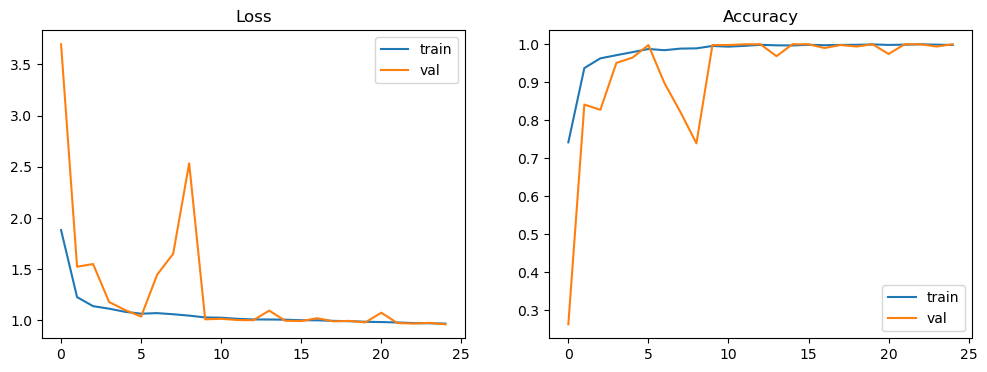

In [10]:
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(hist["loss"], label="train"); plt.plot(hist["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(hist["accuracy"], label="train"); plt.plot(hist["val_accuracy"], label="val"); plt.title("Accuracy"); plt.legend()
plt.show()

In [11]:
model.save("alexnet_attendance.h5")
with open("class_indices.json", "w") as f:
    json.dump({i:c for i,c in enumerate(class_names)}, f, indent=2)

In [18]:
def predict_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    arr = img_to_array(img) / 255.0
    pred = model.predict(arr[None, ...])[0]
    idx = np.argmax(pred)
    return class_names[idx], float(pred[idx])

label, prob = predict_image("/mnt/d/CVPR/CODE/Dataset/22-49824-3/monami1.jpg")
print(label, prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
22-49791-3 0.9979748129844666


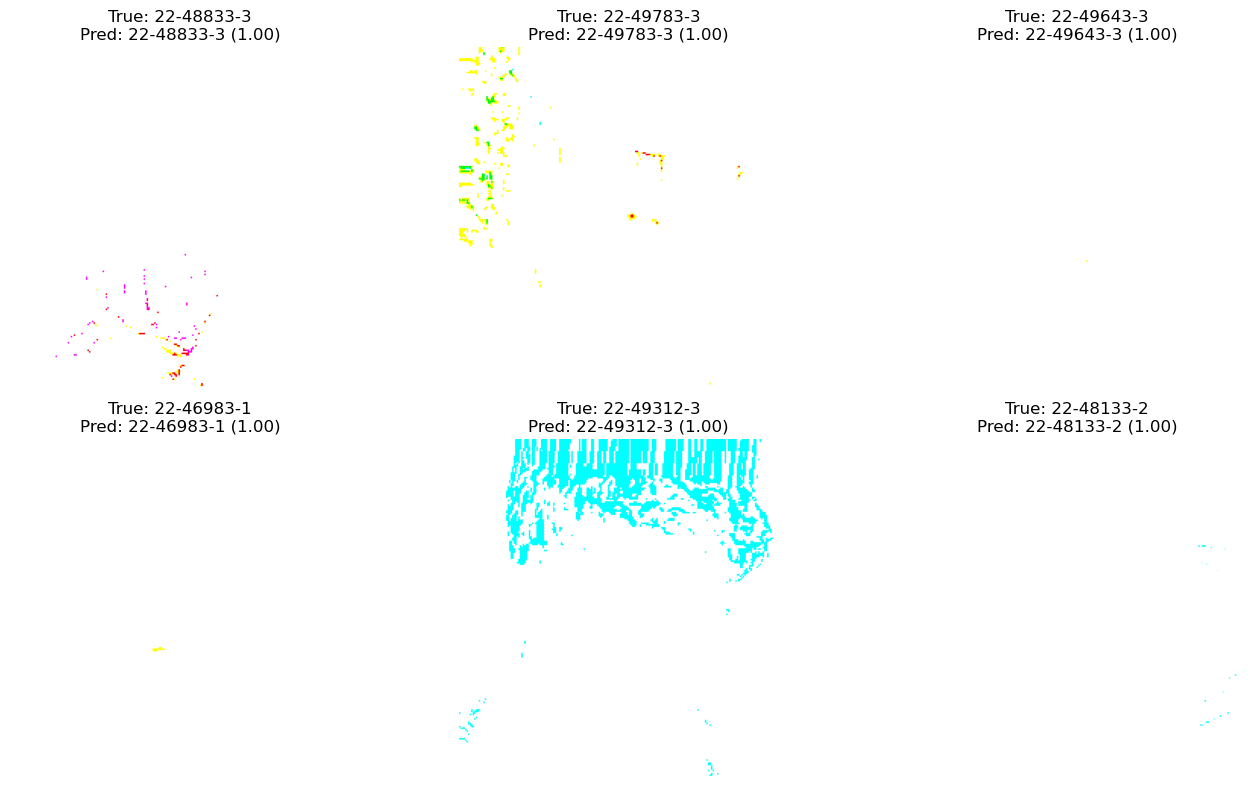

In [19]:
import random

# take a few random samples from the validation set
sample_imgs = []
sample_true = []
for imgs, labels in val_ds.take(1):
    sample_imgs = imgs.numpy()
    sample_true = labels.numpy()
    break

probs = model.predict(sample_imgs, verbose=0)
preds = np.argmax(probs, axis=1)

n_show = min(6, len(sample_imgs))
plt.figure(figsize=(14, 8))
for i in range(n_show):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_imgs[i].astype("float32"))
    plt.axis("off")
    plt.title(f"True: {class_names[sample_true[i]]}\nPred: {class_names[preds[i]]} ({probs[i][preds[i]]:.2f})")
plt.tight_layout()
plt.show()

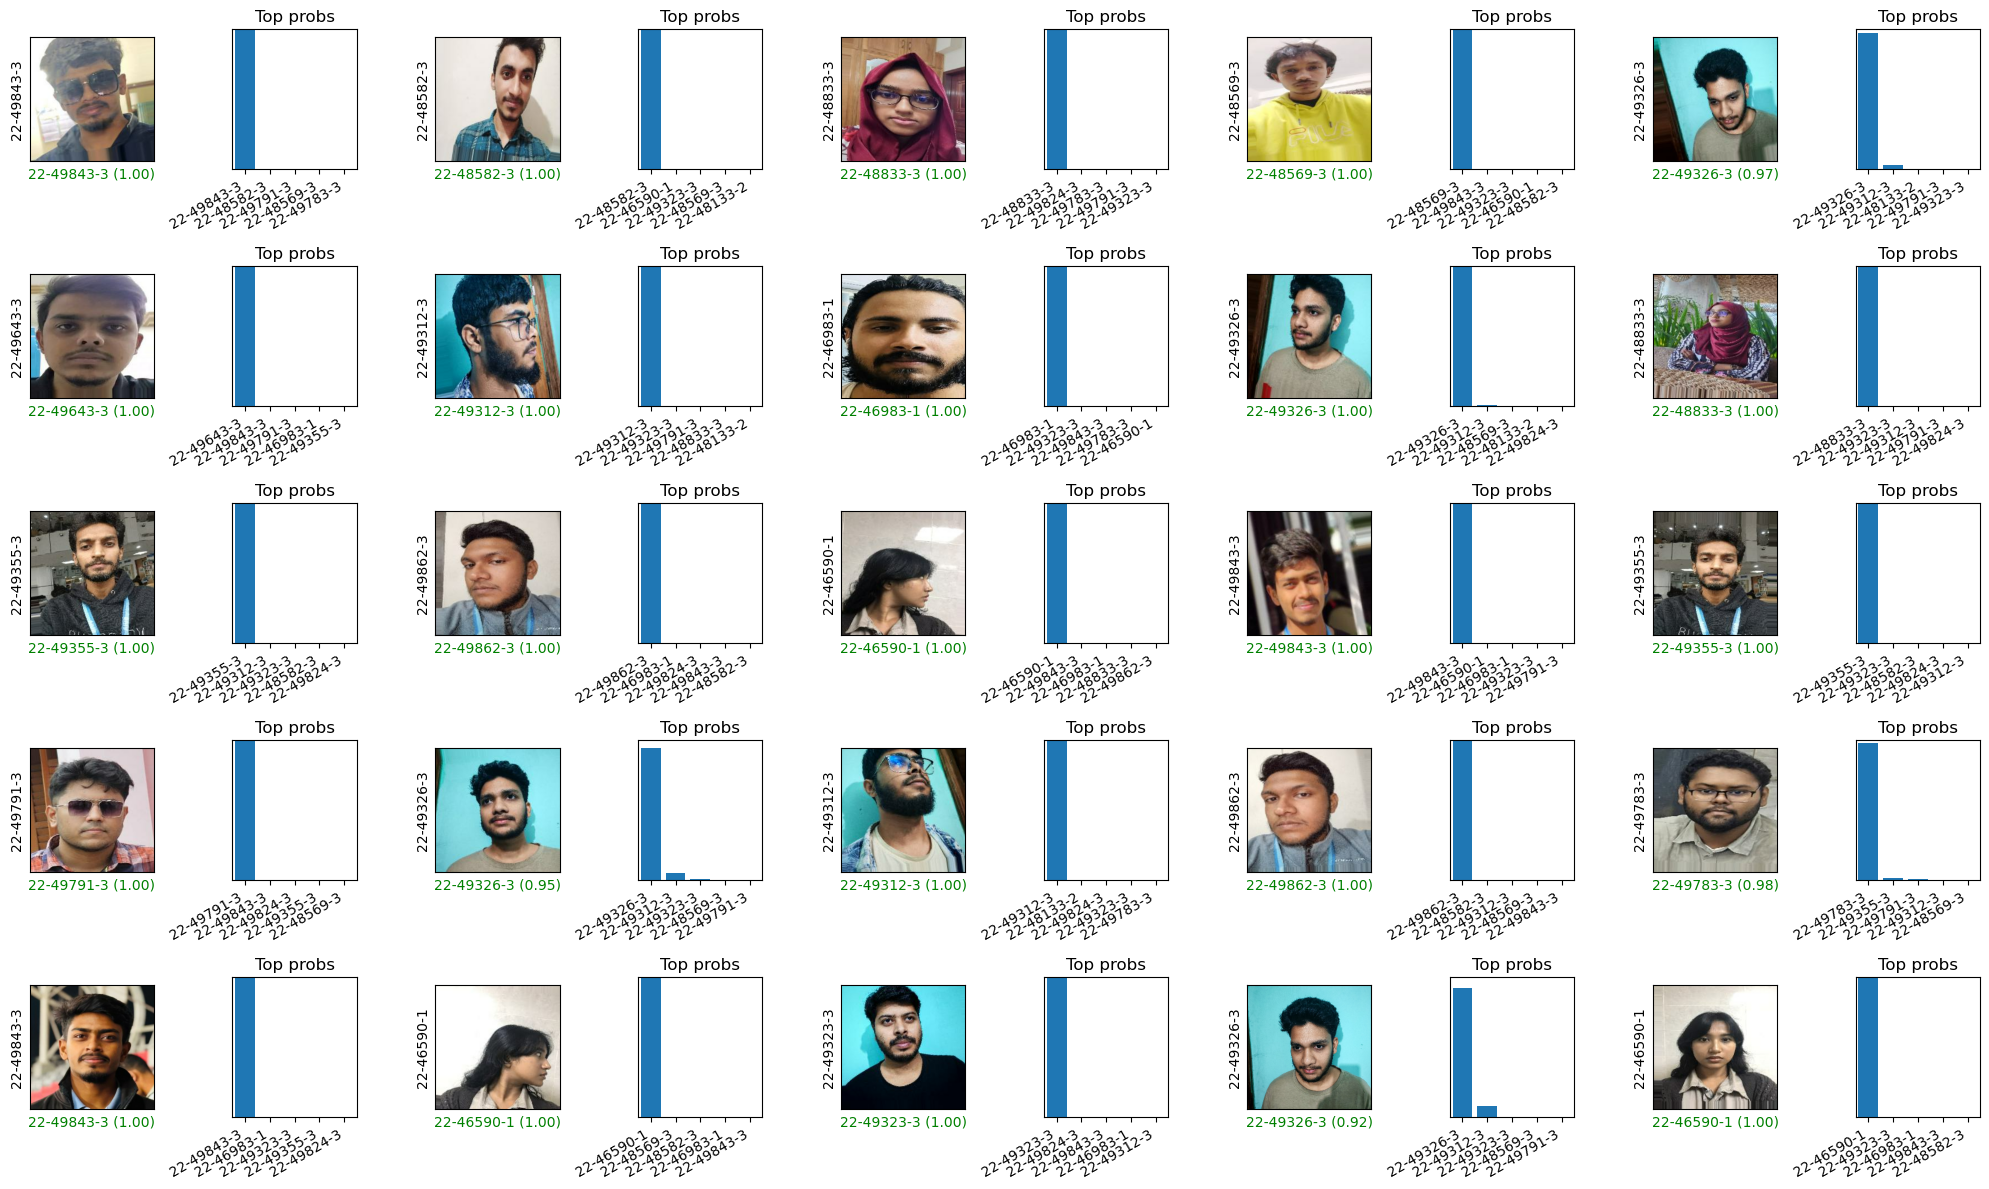

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Take one batch from the validation set
X_batch, y_batch = next(iter(val_ds))
predictions = model.predict(X_batch, verbose=0)

rows = 5
cols = 5
n_show = min(rows * cols, X_batch.shape[0])
k_top = 5  # how many top classes to show in the bar chart

plt.figure(figsize=(20, 12))
for i in range(n_show):
    true_idx = int(y_batch[i].numpy())         # sparse labels
    pred_idx = int(np.argmax(predictions[i]))
    true_label = class_names[true_idx]
    pred_label = class_names[pred_idx]
    pred_conf = predictions[i][pred_idx]

    # Restore image for display
    img = X_batch[i].numpy()
    if img.max() <= 1.5:          # heuristic: assume 0–1 normalized
        img = img * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Left: image with labels
    plt.subplot(rows, 2 * cols, 2 * i + 1)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([])
    plt.ylabel(true_label)
    xlabel_color = 'g' if true_idx == pred_idx else 'r'
    plt.xlabel(f"{pred_label} ({pred_conf:.2f})", color=xlabel_color)

    # Right: top-k bar chart
    plt.subplot(rows, 2 * cols, 2 * i + 2)
    k = min(k_top, len(class_names))
    top_idx = np.argsort(predictions[i])[::-1][:k]
    plt.bar(range(k), predictions[i][top_idx])
    plt.xticks(range(k), [class_names[j] for j in top_idx], rotation=30, ha='right')
    plt.yticks([])
    plt.ylim([0, 1])
    plt.xlim([-0.5, k - 0.5])
    plt.title("Top probs")

plt.tight_layout()
plt.show()

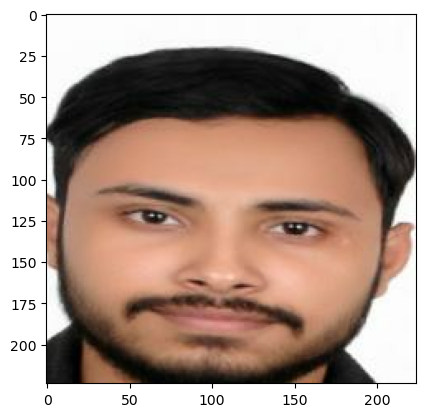

In [21]:
img = X_batch[i].numpy()
# If already 0–1, scale back; if zero-centered, shift/scale appropriately
if img.max() <= 1.5:  # heuristic for 0–1 data
    img = img * 255.0
img = np.clip(img, 0, 255).astype(np.uint8)
plt.imshow(img)

(-0.5, 4.5)

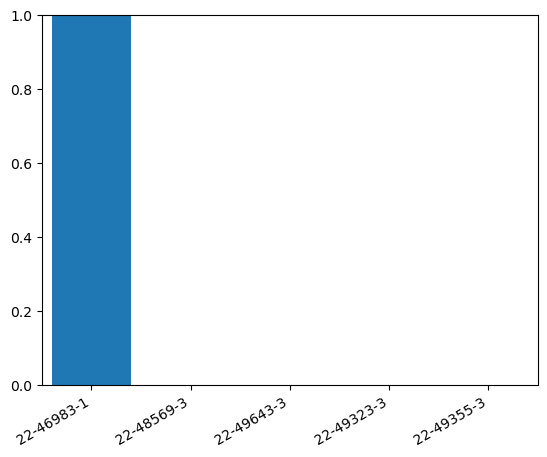

In [22]:
k = min(5, len(class_names))  # show top-5
top_idx = np.argsort(predictions[i])[::-1][:k]
plt.bar(range(k), predictions[i][top_idx])
plt.xticks(range(k), [class_names[j] for j in top_idx], rotation=30, ha='right')
plt.ylim([0, 1])
plt.xlim([-0.5, k-0.5])